In [16]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

preprocessing and preparing the data

In [17]:
# Load and preprocess data
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

In [18]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [19]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128
EPOCHS = 50
noise_dim = 100

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)

defining the model

In [21]:
def make_generator_model():
    model = tf.keras.Sequential([
        # Input processing
        layers.Dense(7*7*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 512)),

        # First upsampling block with residual connection
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Second upsampling block
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Additional convolutional block for feature enhancement
        layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Third upsampling block
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Final refinement layers
        layers.Conv2D(32, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Output layer
        layers.Conv2D(1, (3, 3), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [22]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        # Initial feature extraction
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Enhanced feature extraction
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Additional convolutional layers
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(512, (3, 3), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Dense layers for classification
        layers.Flatten(),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(1)
    ])
    return model

In [23]:
# Initialize models
generator = make_generator_model()
discriminator = make_discriminator_model()

describing the losses and optimizers

In [24]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [26]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
# Optimizers with adjusted parameters
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)


defining the training loop

In [28]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Add L1 regularization for stability
        for weight in generator.trainable_weights:
            gen_loss += 1e-4 * tf.reduce_mean(tf.abs(weight))
        for weight in discriminator.trainable_weights:
            disc_loss += 1e-4 * tf.reduce_mean(tf.abs(weight))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Gradient clipping for stability
    gradients_of_generator = [tf.clip_by_norm(g, 1.0) for g in gradients_of_generator]
    gradients_of_discriminator = [tf.clip_by_norm(g, 1.0) for g in gradients_of_discriminator]

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [29]:
def train(dataset, epochs):
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        epoch_gen_losses = []
        epoch_disc_losses = []

        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)
            epoch_gen_losses.append(gen_loss)
            epoch_disc_losses.append(disc_loss)

        # Calculate average losses for the epoch
        avg_gen_loss = tf.reduce_mean(epoch_gen_losses)
        avg_disc_loss = tf.reduce_mean(epoch_disc_losses)
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        print(f"Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}")

        # Generate and save sample images every 10 epochs
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

    return gen_losses, disc_losses

In [30]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [31]:
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])


training the model


Epoch 1/50
Generator Loss: 1.0004, Discriminator Loss: 1.1921

Epoch 2/50
Generator Loss: 0.9134, Discriminator Loss: 1.2357

Epoch 3/50
Generator Loss: 0.7943, Discriminator Loss: 1.3091

Epoch 4/50
Generator Loss: 0.8042, Discriminator Loss: 1.3049

Epoch 5/50
Generator Loss: 0.8553, Discriminator Loss: 1.2755

Epoch 6/50
Generator Loss: 0.8679, Discriminator Loss: 1.2739

Epoch 7/50
Generator Loss: 0.8612, Discriminator Loss: 1.2814

Epoch 8/50
Generator Loss: 0.8471, Discriminator Loss: 1.2899

Epoch 9/50
Generator Loss: 0.8353, Discriminator Loss: 1.2959

Epoch 10/50
Generator Loss: 0.8276, Discriminator Loss: 1.3014


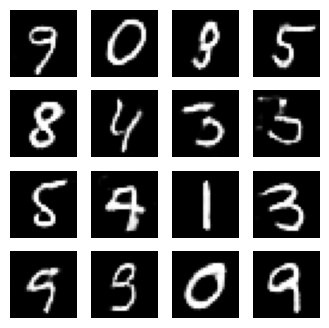


Epoch 11/50
Generator Loss: 0.8169, Discriminator Loss: 1.3090

Epoch 12/50
Generator Loss: 0.8110, Discriminator Loss: 1.3118

Epoch 13/50
Generator Loss: 0.8088, Discriminator Loss: 1.3125

Epoch 14/50
Generator Loss: 0.8054, Discriminator Loss: 1.3151

Epoch 15/50
Generator Loss: 0.8031, Discriminator Loss: 1.3150

Epoch 16/50
Generator Loss: 0.8025, Discriminator Loss: 1.3182

Epoch 17/50
Generator Loss: 0.7996, Discriminator Loss: 1.3192

Epoch 18/50
Generator Loss: 0.8035, Discriminator Loss: 1.3170

Epoch 19/50
Generator Loss: 0.7969, Discriminator Loss: 1.3203

Epoch 20/50
Generator Loss: 0.8011, Discriminator Loss: 1.3181


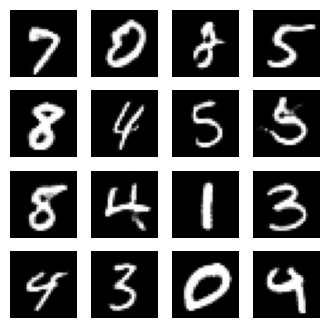


Epoch 21/50
Generator Loss: 0.7975, Discriminator Loss: 1.3205

Epoch 22/50
Generator Loss: 0.7972, Discriminator Loss: 1.3208

Epoch 23/50
Generator Loss: 0.8009, Discriminator Loss: 1.3180

Epoch 24/50
Generator Loss: 0.8039, Discriminator Loss: 1.3165

Epoch 25/50
Generator Loss: 0.8071, Discriminator Loss: 1.3122

Epoch 26/50
Generator Loss: 0.8082, Discriminator Loss: 1.3139

Epoch 27/50
Generator Loss: 0.8094, Discriminator Loss: 1.3108

Epoch 28/50
Generator Loss: 0.8105, Discriminator Loss: 1.3108

Epoch 29/50
Generator Loss: 0.8169, Discriminator Loss: 1.3077

Epoch 30/50
Generator Loss: 0.8143, Discriminator Loss: 1.3113


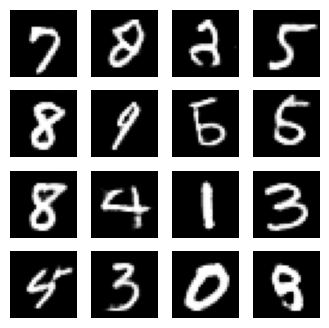


Epoch 31/50
Generator Loss: 0.8159, Discriminator Loss: 1.3096

Epoch 32/50
Generator Loss: 0.8161, Discriminator Loss: 1.3078

Epoch 33/50
Generator Loss: 0.8190, Discriminator Loss: 1.3080

Epoch 34/50
Generator Loss: 0.8194, Discriminator Loss: 1.3078

Epoch 35/50
Generator Loss: 0.8163, Discriminator Loss: 1.3097

Epoch 36/50
Generator Loss: 0.8214, Discriminator Loss: 1.3059

Epoch 37/50
Generator Loss: 0.8191, Discriminator Loss: 1.3085

Epoch 38/50
Generator Loss: 0.8221, Discriminator Loss: 1.3062

Epoch 39/50
Generator Loss: 0.8223, Discriminator Loss: 1.3059

Epoch 40/50
Generator Loss: 0.8225, Discriminator Loss: 1.3049


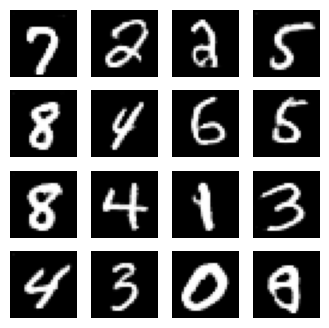


Epoch 41/50
Generator Loss: 0.8228, Discriminator Loss: 1.3051

Epoch 42/50
Generator Loss: 0.8220, Discriminator Loss: 1.3074

Epoch 43/50
Generator Loss: 0.8206, Discriminator Loss: 1.3080

Epoch 44/50
Generator Loss: 0.8266, Discriminator Loss: 1.3030

Epoch 45/50
Generator Loss: 0.8261, Discriminator Loss: 1.3043

Epoch 46/50
Generator Loss: 0.8281, Discriminator Loss: 1.3021

Epoch 47/50
Generator Loss: 0.8314, Discriminator Loss: 1.3001

Epoch 48/50
Generator Loss: 0.8276, Discriminator Loss: 1.3042

Epoch 49/50
Generator Loss: 0.8314, Discriminator Loss: 1.3019

Epoch 50/50
Generator Loss: 0.8284, Discriminator Loss: 1.3039


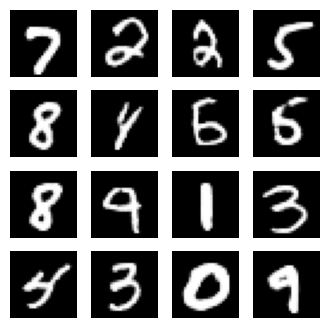

In [32]:
# Train the model
gen_losses, disc_losses = train(train_dataset, EPOCHS)

visualizing the losses

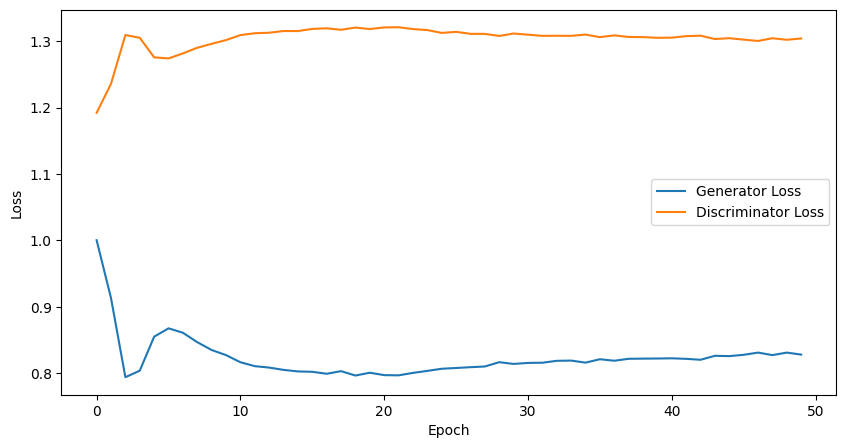

In [33]:
# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

minimum loss for generator and discriminator

In [34]:
print(f"minimum loss for generator is {min(gen_losses)}")
print(f"minimum loss for discriminator is {min(disc_losses)}")

minimum loss for generator is 0.7943484783172607
minimum loss for discriminator is 1.1920578479766846
